# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

For the project of determining what drives the used price of a call, interviews with sales teams and management teams is necessary.  The following are questions that should drive the process of understanding the data.

The goal of this project is to identify the major factors that contribute to the changes in used car sales prices and provide recommendations as to which vehicles to target to help drive the profitability of the used cars sales business.

1.  How have gas prices and unemployment rates affected used car prices?
2.  Do interest rates / or payment amounts affect prices?
3.  Demographics / credit scores affect purchase prices?
4.  Which vehicles typically have the highest margins to seek ways to maximize profitability.
5.  Can the VIN numbers be searched in a 3rd party database to bring back vehicle specific information to improve forecasting.
6.  Which vehicles have the highest repairs and maintenance that could be used to create future revenue opportunities for the service department.
7.  Unemployment data and past due rates on vehicle types could also be used to predict excess supply that could affect prices.


### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

A review of the data found a lot of cleaning needed to be done to be able to effectively analyze used car prices.  Here is a list of items that were found and performed:

1.  The data table contained numerous duplicate VIN numbers.  In addition, number duplicates to vehicles that had null VIN numbers were removed.
2.  After researching VIN numbers, after 1981, the worldwide standard is 17 digits.  From the VIN number, important features can be derived.  These features were added to the dataframe.  See this link for info: https://en.wikipedia.org/wiki/Vehicle_identification_number.
3.  Model names appeared to be freeform and too difficult to clean into categorical features that wouldn't result in a high number of features after running one-hot-encoder.  As a result, used the model from the VIN number.
4.  Excluded vehicles that were older than 25 years as they were antique vehicles.
5.  Converted sales prices to a lognormal distribution and filtered out outliers so data wasn't skewed.
6.  Excluded vehicles that had mileages over 250,000 miles as many were freightliners and wouldn't fit the typical used car category.
7.  Excluded vehicles with missing titles, were for parts or had a condition of new as these were not typical "used car" sales types.

In [481]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, OrdinalEncoder, FunctionTransformer, StandardScaler
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance

# Set display options to show large numbers as is, without scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [482]:
# The VIN number contains a lot of information.
#    First 3 digits are vehicle manufacturer.
#    Characters 4 through 9 are the Vehicle Descriptor Section that provide info on model, enginetype, body style, ect.
#    The 10th character indicates the model year.
#    The 11th character identifies the plan where it was assembled.
#    Characters 12 through 17 are unique serial number indicating it's production sequence.

# Gas mileage would be a good feature to have.

In [483]:
cars = pd.read_csv('data/vehicles.csv')

In [484]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [485]:
cars.describe()

,id,price,year,odometer
count,426880.00,426880.00,425675.00,422480.00
mean,7311486634.22,75199.03,2011.24,98043.33
std,4473170.41,12182282.17,9.45,213881.50
min,7207408119.00,0.00,1900.00,0.00
25%,7308143339.25,5900.00,2008.00,37704.00
50%,7312620821.00,13950.00,2013.00,85548.00
75%,7315253543.50,26485.75,2017.00,133542.50
max,7317101084.00,3736928711.00,2022.00,10000000.00


In [486]:
# there were duplicate vin numbers.  
cars[cars['VIN'].notna()].duplicated(subset='VIN').sum()

147592

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [487]:
# dropping any duplicate VINs for rows that have VIN numbers.

cars_vin_notna = cars[cars['VIN'].notna()].drop_duplicates(subset='VIN', keep='first')
cars_vin_notna = cars_vin_notna[cars_vin_notna['VIN'].apply(lambda x: len(str(x)) == 17)]

cars_vin_notna.head(5)

cars_vin_na = cars[cars['VIN'].isna()]

In [488]:
# creating cars dataframe without duplicates

cars_not_duped = pd.concat([cars_vin_notna, cars_vin_na], ignore_index=True)

In [489]:
# removing duplicate rows by evaluating all columns except the ID column

dupe_cols_eval = list(cars_not_duped.columns)
dupe_cols_eval.remove('id')
dupe_cols_eval

cars_not_duped = cars_not_duped.drop_duplicates(subset=dupe_cols_eval, keep='first')

In [490]:
cars_not_duped.describe()

,id,price,year,odometer
count,260294.00,260294.00,259655.00,257370.00
mean,7312180392.23,108927.90,2009.57,112490.86
std,4332525.89,15600692.81,10.51,245376.09
min,7207408119.00,0.00,1900.00,0.00
25%,7309467557.75,4900.00,2007.00,52290.25
50%,7313624086.00,10000.00,2012.00,100000.00
75%,7315595948.50,19995.00,2016.00,146000.00
max,7317101084.00,3736928711.00,2022.00,10000000.00


In [491]:
# removing antique cars from the list.  Vehicles older than 25 years.

cars_not_duped = cars_not_duped.query('year > 1997')

# removing outlier car values

cars_not_duped = cars_not_duped.query('price >= 1500 & price < 550000')

# removing high odometer vehicles as most were freightliners.

cars_not_duped = cars_not_duped.query('odometer > 10 & odometer < 250000')

# getting rid of vehicles that wouldn't be considered a normal used sale.

cars_not_duped = cars_not_duped.query('title_status not in ("missing", "parts only")')
cars_not_duped = cars_not_duped.query('condition != "new" ')

# after modeling Ridge, decided to drop all remaining rows that didn't have a VIN to see if improved R2.  It improved 3%.


# THIS IS THE ONE I WANT TO RUN
cars_not_duped = cars_not_duped.dropna(subset=['VIN', 'condition'])

# cars_not_duped = cars_not_duped.dropna()

In [492]:
# converting cylinders to numeric

cars_not_duped['cylinders_numeric'] = cars_not_duped['cylinders'].apply(lambda x: int(str(x)[0:2].strip()) \
                                                    if str(x)[0:2].strip().isdigit() == True else -1)

In [493]:
# calculating the age of a vehicle.  If year is 0, did .5.

cars_not_duped['age'] = cars_not_duped['year'].apply(lambda y: 2022 - y if y < 2022 else .5)

In [494]:
# Adding a mileage per age feature to possibly help prediction

cars_not_duped['miles_per_age'] = cars_not_duped['odometer'] / cars_not_duped['age']

In [495]:
# Breaking VIN Number into different components to get more features

cars_not_duped['vin_manufacturer_country'] = cars_not_duped['VIN'].str[0:1]
cars_not_duped['vin_manufacturer'] = cars_not_duped['VIN'].str[1:2]
cars_not_duped['vin_manufacturer_division'] = cars_not_duped['VIN'].str[2:3]
cars_not_duped['vin_manufacturer_series'] = cars_not_duped['VIN'].str[3:4]
cars_not_duped['vin_manufacturer_model'] = cars_not_duped['VIN'].str[4:5]
cars_not_duped['vin_manufacturer_body_style'] = cars_not_duped['VIN'].str[5:6]
cars_not_duped['vin_manufacturer_engine_type'] = cars_not_duped['VIN'].str[6:7]
cars_not_duped['vin_manufacturer_year'] = cars_not_duped['VIN'].str[9:10]

In [496]:
manu_map = pd.DataFrame(cars_not_duped[['manufacturer', 'vin_manufacturer_division']
                                      ].value_counts()).reset_index()

In [497]:
manu_map = manu_map.drop([0], axis=1)
manu_map = manu_map.drop_duplicates(subset='vin_manufacturer_division', keep='first').set_index('vin_manufacturer_division')
cars_not_duped['manufacturer'] = cars_not_duped['manufacturer'].fillna(cars_not_duped['vin_manufacturer'].map(manu_map['manufacturer']))

In [498]:
cars_not_duped.head(3)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,...,age,miles_per_age,vin_manufacturer_country,vin_manufacturer,vin_manufacturer_division,vin_manufacturer_series,vin_manufacturer_model,vin_manufacturer_body_style,vin_manufacturer_engine_type,vin_manufacturer_year
0,7316814884,auburn,33590,2014.00,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.00,...,8.00,7240.38,3,G,T,P,1,V,E,E
1,7316814758,auburn,22590,2010.00,chevrolet,silverado 1500,good,8 cylinders,gas,71229.00,...,12.00,5935.75,1,G,C,S,C,S,E,A
2,7316814989,auburn,39590,2020.00,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.00,...,2.00,9580.00,3,G,C,P,W,C,E,L


In [499]:
cols_to_drop = ['cylinders','size','model','VIN','age', 'region']
cars_not_duped = cars_not_duped.drop(cols_to_drop, axis=1)

In [500]:
for c in cars_not_duped.columns:
    print(f'column value count: {c}')
    print(pd.DataFrame(cars_not_duped[c].value_counts().sort_values(ascending=True)))
    print('\n\n')

column value count: id
            id
7316814884   1
7313857831   1
7314584291   1
7316814989   1
7316743432   1
...         ..
7306727130   1
7306692437   1
7306691877   1
7311623471   1
7303723154   1

[52464 rows x 1 columns]



column value count: price
       price
20136      1
33830      1
28300      1
33100      1
28940      1
...      ...
5995     537
8995     617
9995     628
7995     646
6995     677

[5990 rows x 1 columns]



column value count: year
         year
2022.00     1
2021.00   137
1998.00   186
1999.00   297
2000.00   345
2001.00   441
2002.00   659
2003.00   854
2004.00  1112
2005.00  1356
2006.00  1703
2009.00  1874
2007.00  2097
2020.00  2214
2010.00  2375
2008.00  2510
2019.00  2800
2011.00  3050
2012.00  3538
2016.00  3548
2015.00  4016
2017.00  4163
2014.00  4188
2018.00  4469
2013.00  4531



column value count: manufacturer
                 manufacturer
aston-martin                1
land rover                  2
ferrari                     8
harley-davids

In [501]:
cars_not_duped.describe()

,id,price,year,odometer,cylinders_numeric,miles_per_age
count,52464.00,52464.00,52464.00,52464.00,52464.00,52464.00
mean,7312020186.10,17825.78,2012.63,92928.63,4.00,10188.75
std,4277577.81,13028.87,4.97,55476.00,3.22,5260.48
min,7301588247.00,1500.00,1998.00,11.00,-1.00,1.89
25%,7309203827.50,8447.75,2009.00,44976.25,-1.00,6750.00
50%,7313394488.50,14900.00,2013.00,92000.00,4.00,9655.76
75%,7315544653.00,23995.00,2017.00,131650.25,6.00,12875.00
max,7317098990.00,347999.00,2022.00,249929.00,12.00,279400.00


In [502]:
cars_not_duped.corr()['price']

id                  -0.06
price                1.00
year                 0.57
odometer            -0.55
cylinders_numeric   -0.00
miles_per_age       -0.14
Name: price, dtype: float64

In [503]:
cars_not_duped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52464 entries, 0 to 117223
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            52464 non-null  int64  
 1   price                         52464 non-null  int64  
 2   year                          52464 non-null  float64
 3   manufacturer                  52461 non-null  object 
 4   condition                     52464 non-null  object 
 5   fuel                          52459 non-null  object 
 6   odometer                      52464 non-null  float64
 7   title_status                  50779 non-null  object 
 8   transmission                  52449 non-null  object 
 9   drive                         43171 non-null  object 
 10  type                          48492 non-null  object 
 11  paint_color                   42536 non-null  object 
 12  state                         52464 non-null  object 
 13  

In [504]:
cars_not_duped = cars_not_duped.fillna('-1')

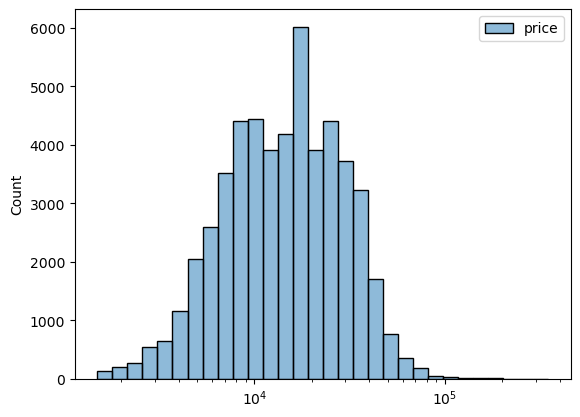

In [505]:
# The target variable had a better distribution on a logged scale.

sns.histplot(cars_not_duped[['price']], bins=30, log_scale=True)
plt.show()

In [506]:
# converting columns with numeric values to numeric

for c in cars_not_duped.columns:

    cars_not_duped[c] = pd.to_numeric(cars_not_duped[c], errors='ignore')

In [507]:
cars_clean = cars_not_duped.set_index('id')

In [508]:
cars_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52464 entries, 7316814884 to 7303723154
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   price                         52464 non-null  int64  
 1   year                          52464 non-null  float64
 2   manufacturer                  52464 non-null  object 
 3   condition                     52464 non-null  object 
 4   fuel                          52464 non-null  object 
 5   odometer                      52464 non-null  float64
 6   title_status                  52464 non-null  object 
 7   transmission                  52464 non-null  object 
 8   drive                         52464 non-null  object 
 9   type                          52464 non-null  object 
 10  paint_color                   52464 non-null  object 
 11  state                         52464 non-null  object 
 12  cylinders_numeric             52464 non-null  

### Column Transformations

In [509]:
X = cars_clean.drop('price', axis=1)
y = cars_clean['price']

In [510]:
# getting non-numeric columns

non_numeric_columns = X.select_dtypes(exclude=[np.number]).columns.tolist()
numeric_columns = X.select_dtypes(exclude='object').columns.tolist()

In [511]:
ohe = OneHotEncoder(sparse=False, drop='if_binary')
sclr = StandardScaler()


transformer = make_column_transformer(
                                            (ohe, non_numeric_columns),
                                            (sclr, numeric_columns),
                                            remainder='passthrough'
                                    )

In [512]:
transformed_data = transformer.fit_transform(X)

In [513]:
X_transform = pd.DataFrame(transformed_data, columns=transformer.get_feature_names_out())

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

### Running PCA

In [514]:
pca = PCA(random_state=42)
X_pca = pca.fit(X_transform)

In [515]:
X_pca_variance_ratio = X_pca.explained_variance_ratio_

evr = X_pca_variance_ratio[0:15]
print(evr.sum())

n_comp = len(evr)

0.4615541234250157


''

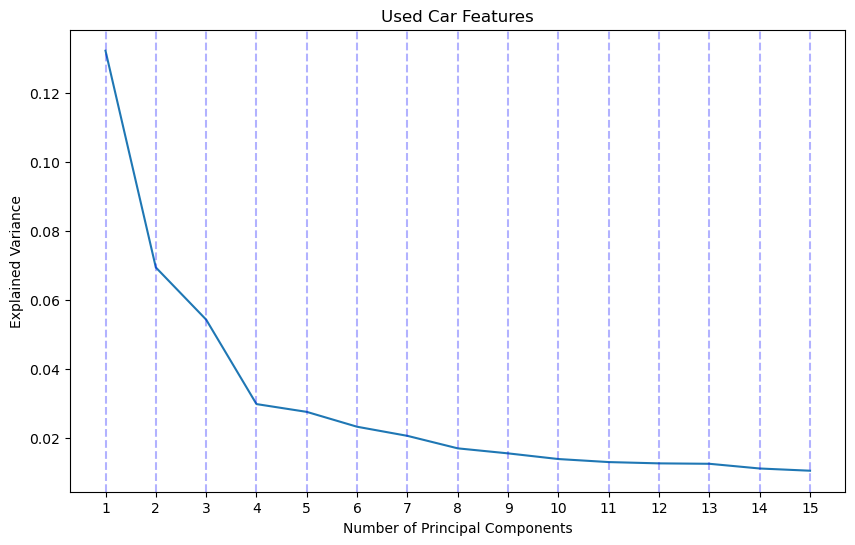

In [516]:
plt.figure(figsize = (10,6))
plt.plot(range(1,n_comp + 1), evr)
plt.title('Used Car Features')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance')
plt.xticks(range(1, n_comp + 1))

for i in range(1, n_comp + 1):
    plt.axvline(x=i, color='blue', linestyle='--', alpha=0.3)
    
plt.savefig('Used_Car_Feature_PCA.png')
;

In [517]:
pca_final = PCA(n_components=14, random_state=42)
pca_column_names = [f'PCA_{i+1}' for i in range(14)]

In [518]:
X_pca_final = pd.DataFrame(pca_final.fit_transform(X_transform),columns=pca_column_names)

### Split and Model Data

In [519]:
X_train, X_test, y_train, y_test = train_test_split(X_pca_final, y, test_size=0.30, random_state=42)

In [520]:
target_transformer = TransformedTargetRegressor(regressor=Ridge(), func=np.log, inverse_func=np.exp)

In [521]:
params_dict = {
                    'poly__degree':[1,2,3],
                    'ridge__regressor__alpha': [.1, 1, 10, 100, 1000]}

pipe = Pipeline([
                    ('poly',PolynomialFeatures(include_bias=False)),
                    ('ridge',target_transformer)
])

In [522]:
# run gridsearch on target_transformer that contains the pipeline.

grid = GridSearchCV(
                        estimator = pipe, 
                        param_grid=params_dict,
                        cv = 5,
                        scoring = 'neg_mean_squared_error',
                        return_train_score=True
                       )

In [523]:
grid_fit = grid.fit(X_train,y_train)

In [524]:
grid_fit.best_params_

{'poly__degree': 3, 'ridge__regressor__alpha': 1}

In [525]:
grid_fit.best_score_

-44287566.227940395

In [526]:
grid_fit.best_estimator_.score(X_train, y_train)

0.7503355236305265

In [527]:
test_r2 = grid_fit.best_estimator_.score(X_test, y_test)
test_r2

0.7252034753989

In [528]:
pca_feature_names = grid.best_estimator_.named_steps.poly.get_feature_names_out()

In [529]:
fimp = permutation_importance(grid_fit.best_estimator_,X_train,y_train, n_repeats=30, random_state=0, scoring='r2')

In [530]:
results = {}

for i in fimp.importances_mean.argsort()[::-1]:
    if fimp.importances_mean[i] - 2 * fimp.importances_std[i] > 0:
        results[pca_feature_names[i]] = {
            'mean': f"{fimp.importances_mean[i]:.3f}",
            'std +/-': f"{fimp.importances_std[i]:.3f}"
        }

results_df = pd.DataFrame(results).transpose()
results_df

,mean,std +/-
PCA_1,1.292,0.120
PCA_3,0.810,0.022
PCA_7,0.223,0.012
PCA_5,0.178,0.005
PCA_9,0.148,0.010
PCA_2,0.145,0.004
PCA_6,0.138,0.006
PCA_8,0.132,0.005
PCA_13,0.113,0.004
PCA_14,0.098,0.005


In [531]:
loadings = pca_final.components_

# Map the loadings to the feature names
for i, component in enumerate(loadings):
    component_loadings = dict(zip(X_transform.columns, component))
    sorted_loadings = sorted(component_loadings.items(), key=lambda x: x[1], reverse=True)
    print(f"Principal Component {i+1}:")
    for feature, loading in sorted_loadings:
        print(f"{feature}: {loading}")
    print()

Principal Component 1:
standardscaler__odometer: 0.6149959816593901
standardscaler__cylinders_numeric: 0.3840143960929781
standardscaler__miles_per_age: 0.34482269751860767
onehotencoder__transmission_automatic: 0.13754678803081263
onehotencoder__condition_excellent: 0.10044630227346131
onehotencoder__drive_4wd: 0.08651027904377193
onehotencoder__vin_manufacturer_country_1: 0.05878196753934872
onehotencoder__fuel_gas: 0.0534922333470498
onehotencoder__type_truck: 0.0397360419709938
onehotencoder__type_SUV: 0.034513860548761405
onehotencoder__vin_manufacturer_F: 0.0313475442026174
onehotencoder__vin_manufacturer_G: 0.02820968950134409
onehotencoder__manufacturer_ford: 0.02798001804547932
onehotencoder__vin_manufacturer_engine_type_8: 0.027636502430740343
onehotencoder__vin_manufacturer_model_K: 0.02684917605673326
onehotencoder__vin_manufacturer_engine_type_3: 0.026568541226391042
onehotencoder__vin_manufacturer_body_style_1: 0.025968388207234516
onehotencoder__vin_manufacturer_year_8: 

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

There were a lot of duplicate values that had to be removed to improve the quality of the data.  VIN numbers were missing for a
lot of vehicles.  If I just look at a list of cars that had 17 digit VIN numbers, the R2 of the model was 59%.  If I only look at vehicles that have VIN numbers and no missing values in the condition column and assign -1 to missing values in the other features, R2 goes up to 75%.  The test data showed similar results with an R2 of 72%.  

To make this model even more accurate, the VIN detailed data needs to be connected to a 3rd party API to improve accuracy of data scraped and to provide more granularity on trim levels.  In addition, that information could be used to populate the values the source of this data came from and there appeared to be freeform responses in many columns (model especially).

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

RESULTS:

When looking at the principle component loadings, the data shows that vehicle values are positively influenced by the following characteristics:

1.  Newer
2.  Low miles
3.  Front wheel drive
4.  Sedans
5.  Japanese made - Toyota and Honda
6.  Excellent condition
7.  Made by GM, specifically Chevrolet brands.

Note:  A very useful metric would be the dealership incorporating gross margins in with this data to determine the most
profitable vehicle model to sell.